# Import data
Import data from a file containing the preprocessed dataset.

In [247]:
import pandas as pd
import os

# depending on the OS the path to the data file is different
if os.name == 'nt':
    data = pd.read_csv(r'..\data\generated\preprocessed-data-classification.csv')
    food_groups = pd.read_excel(r'..\data\food-groups.xls')
elif os.name == 'posix':
    data = pd.read_csv(r'../data/generated/preprocessed-data-classification.csv')
    food_groups = pd.read_excel(r'../data/food-groups.xls')

# filter food groups with 'Food Group Code' with length 2
food_groups = food_groups[food_groups['Food Group Code'].apply(lambda x: len(str(x)) == 2)]

data.head()

,Public Food Key,Classification,Food Name,"Energy with dietary fibre, equated \n(kJ)","Energy, without dietary fibre, equated \n(kJ)",Moisture (water) \n(g),Protein \n(g),Nitrogen \n(g),"Fat, total \n(g)",Ash \n(g),...,C20:5w3 (mg),C22:5w3 (mg),C22:4w6 (mg),C22:6w3 (mg),"Total polyunsaturated fatty acids, equated \n(g)","Total long chain omega 3 fatty acids, equated \n(mg)","Total trans fatty acids, imputed \n(mg)",Cholesterol \n(mg),Tryptophan \n(mg/gN),Tryptophan \n(mg)
0,F002258,31,"Cardamom seed, dried, ground",1236,1012,8.3,10.8,1.72,6.7,5.8,...,0.00,0.00,31.0,0.0,1.39,0.000,0.0,0,90.0,155
1,F002893,31,"Chilli (chili), dried, ground",1280,1002,10.8,13.4,2.14,14.3,11.8,...,0.00,0.00,31.0,0.0,6.69,0.000,0.0,0,32.0,69
2,F002963,31,"Cinnamon, dried, ground",1004,579,10.6,4.0,0.64,1.2,3.6,...,0.00,0.00,31.0,0.0,0.12,0.000,0.0,0,77.0,49
3,F002970,31,"Cloves, dried, ground",1389,1118,9.9,6.0,0.96,13.0,5.6,...,11.06,255.52,31.0,0.0,5.03,266.581,0.0,0,31.0,30
4,F003190,31,"Coriander seed, dried, ground",1344,1009,8.9,12.4,1.98,17.8,6.0,...,0.00,0.00,31.0,0.0,1.82,0.000,0.0,0,90.0,178


---
# Prepare data
1. Determine the target variable.
2. Determine the features.
3. Split the data into training and test sets.

In [248]:
# use nutrition columns as features
X_COLS = list(data.columns[3:])

# use classification column as target
y_COL = data.columns[1]

print(f"X_COLS: {X_COLS}")
print(f"y_COL: {y_COL}")

X_COLS: ['Energy with dietary fibre, equated \n(kJ)', 'Energy, without dietary fibre, equated \n(kJ)', 'Moisture (water) \n(g)', 'Protein \n(g)', 'Nitrogen \n(g)', 'Fat, total \n(g)', 'Ash \n(g)', 'Total dietary fibre \n(g)', 'Fructose \n(g)', 'Glucose \n(g)', 'Sucrose\n(g)', 'Total sugars (g)', 'Starch \n(g)', 'Available carbohydrate, without sugar alcohols \n(g)', 'Available carbohydrate, with sugar alcohols \n(g)', 'Citric acid \n(g)', 'Lactic acid \n(g)', 'Malic acid\n (g)', 'Oxalic acid \n(g)', 'Quinic acid \n(g)', 'Calcium (Ca) \n(mg)', 'Chloride (Cl) \n(mg)', 'Copper (Cu) \n(mg)', 'Iodine (I) \n(ug)', 'Iron (Fe) \n(mg)', 'Magnesium (Mg) \n(mg)', 'Manganese (Mn) \n(mg)', 'Phosphorus (P) \n(mg)', 'Potassium (K) \n(mg)', 'Selenium (Se) \n(ug)', 'Sodium (Na) \n(mg)', 'Sulphur (S) \n(mg)', 'Zinc (Zn) \n(mg)', 'Retinol (preformed vitamin A) \n(ug)', 'Alpha-carotene \n(ug)', 'Beta-carotene \n(ug)', 'Cryptoxanthin \n(ug)', 'Beta-carotene equivalents (provitamin A) \n(ug)', 'Vitamin A re

In [249]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, test = train_test_split(data, test_size=0.15, random_state=43)

# create design matrix X and predictions y
X_train = train[X_COLS]
y_train = train[y_COL]
X_test = test[X_COLS]
y_test = test[y_COL]

---
# $k$-nn
We create a $k$-nn model which is used to classify a food into different food groups based on its nutritional information.

First we determine the best $k$ value based on the accuracy of different models.

Best k: 1


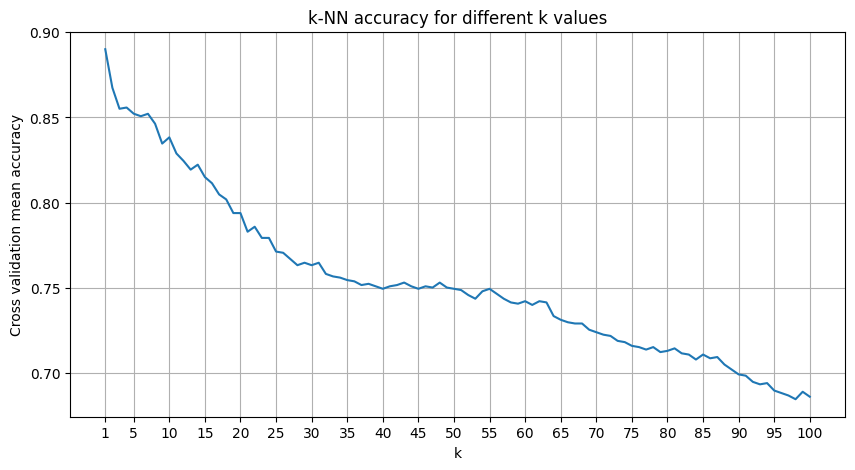

In [250]:
# find the best k based on accuracy using cross validation

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def cross_validate(X_train, y_train):
    # create list of possible k values from 1 to 100
    k_values = list(range(1, 101))

    # create list of cross validation scores
    cv_scores = []

    # perform 10-fold cross validation for each k 
    # and take the mean of the scores
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # find the best k
    best_k = k_values[cv_scores.index(max(cv_scores))]
    print(f"Best k: {best_k}")

    # plot the accuracy for each k
    plt.plot(k_values, cv_scores)
    plt.xlabel("k")
    plt.ylabel("Cross validation mean accuracy")

    # add xtick for every 5th k
    plt.xticks([1] + list(range(5, 101, 5)))

    plt.grid()
    plt.gcf().set_size_inches(10, 5)
    plt.title("k-NN accuracy for different k values")

    # save the plot
    plt.savefig('../report/figs/knn-cross-validation.png', bbox_inches='tight')

    return best_k

best_k = cross_validate(X_train, y_train)

In [251]:
KNN_NEIGHBORS = best_k

# create knn with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)

# replace NaN values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# train the model using the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [252]:
def predict_y(X_test):
    # predict the labels of the test set
    return knn.predict(X_test)

y_pred = predict_y(X_test)

## Evaluation
Calculate certain metrics to evaluate the model.

### Accuracy

In [253]:
# check the accuracy
from sklearn.metrics import accuracy_score

def print_accuracy_and_predictions(y_test, y_pred):
    # y_test constains the true labels of the test set
    # y_pred contains the predicted labels of the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # compare manually predicted labels with the true labels
    print(f"First few predictions: {y_pred[:10]}")
    print(f"First few true labels: {y_test[:10].values}")

    return accuracy
    
print_accuracy_and_predictions(y_test, y_pred)

Accuracy: 0.9506172839506173
First few predictions: [24 31 24 31 18 31 31 31 31 31]
First few true labels: [24 31 24 31 18 31 31 31 31 31]


0.9506172839506173

### Confusion Matrix

Correct predictions per food group:
24: 28 (Vegetable products and dishes)
31: 70 (Miscellaneous)
18: 85 (Meat, poultry and game products and dishes)
15: 18 (Fish and seafood products and dishes)
16: 8 (Fruit products and dishes)
12: 22 (Cereals and cereal products)


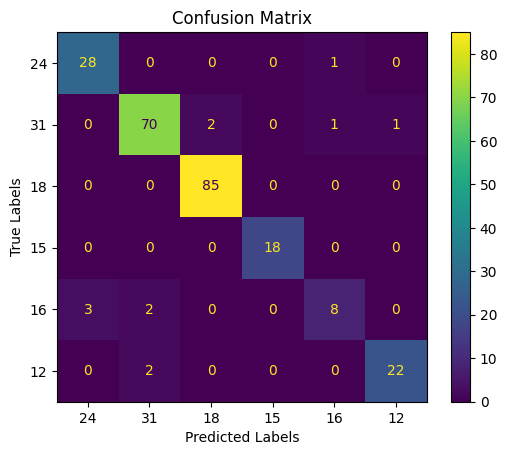

In [254]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_cm(y_test, y_pred, save_fig=False):
    # count the number of correct predictions
    print("Correct predictions per food group:")
    for value in y_test.unique():
        correct = 0
        for i in range(len(y_test)):
            if y_test.values[i] == y_pred[i] and y_test.values[i] == value:
                correct += 1
        food_group_name = food_groups[food_groups['Food Group Code'] == value]['Food Group and Sub-Group Name'].values[0].strip()
        print(f"{value}: {correct} ({food_group_name})")

    # create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

    # create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # plot confusion matrix
    disp.plot()
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # plot the labels on the x and y axis
    plt.xticks(range(len(y_test.unique())), y_test.unique())
    plt.yticks(range(len(y_test.unique())), y_test.unique())

    plt.show()

    if save_fig:
        disp.figure_.savefig('../report/figs/knn-confusion-matrix.png', bbox_inches='tight')

print_cm(y_test, y_pred, save_fig=True)

### Cross Validation


Accuracy: 0.9320987654320988
First few predictions: [31 31 16 18 31 31 31 31 31 31]
First few true labels: [31 31 31 31 31 31 31 31 31 31]
Correct predictions per food group:
31: 97 (Miscellaneous)
12: 25 (Cereals and cereal products)
16: 14 (Fruit products and dishes)
18: 106 (Meat, poultry and game products and dishes)
15: 24 (Fish and seafood products and dishes)
24: 36 (Vegetable products and dishes)


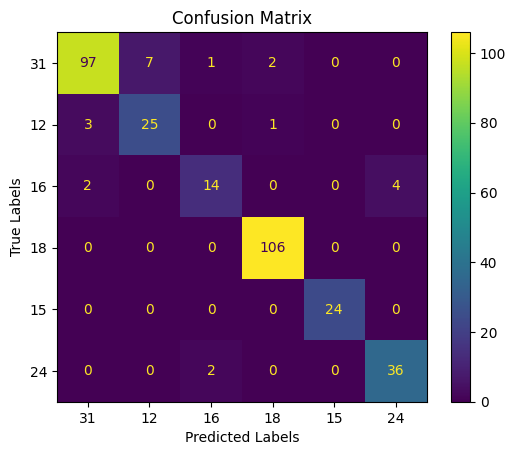

Accuracy: 0.8792569659442725
First few predictions: [31 31 31 31 31 31 12 31 31 31]
First few true labels: [31 31 31 31 31 12 24 31 31 31]
Correct predictions per food group:
31: 83 (Miscellaneous)
12: 29 (Cereals and cereal products)
24: 44 (Vegetable products and dishes)
18: 81 (Meat, poultry and game products and dishes)
16: 20 (Fruit products and dishes)
15: 27 (Fish and seafood products and dishes)


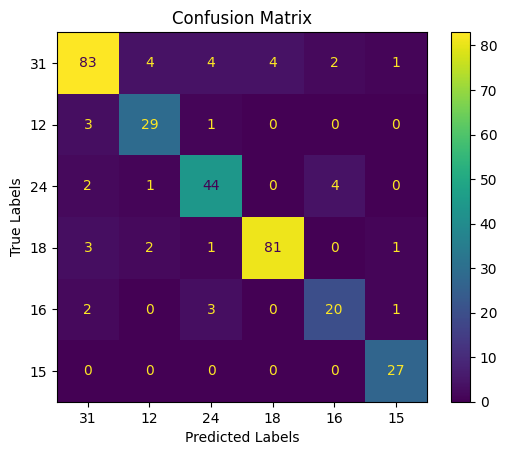

Accuracy: 0.8885448916408669
First few predictions: [24 31 31 31 31 16 31 31 31 31]
First few true labels: [31 31 31 31 31 31 31 31 31 31]
Correct predictions per food group:
31: 75 (Miscellaneous)
12: 31 (Cereals and cereal products)
15: 18 (Fish and seafood products and dishes)
16: 22 (Fruit products and dishes)
24: 42 (Vegetable products and dishes)
18: 99 (Meat, poultry and game products and dishes)


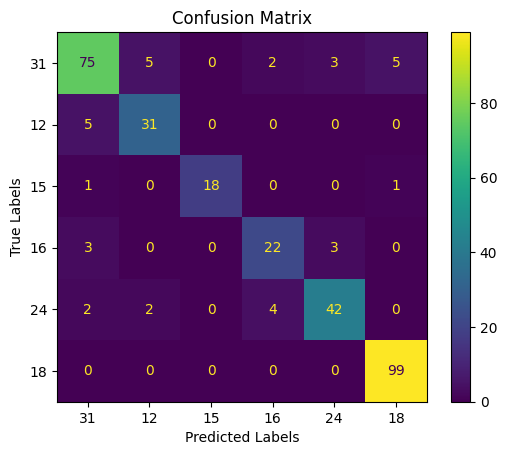

Accuracy: 0.8885448916408669
First few predictions: [31 31 31 31 31 31 31 31 24 31]
First few true labels: [31 31 31 31 31 31 31 31 31 31]
Correct predictions per food group:
31: 92 (Miscellaneous)
12: 26 (Cereals and cereal products)
16: 20 (Fruit products and dishes)
24: 45 (Vegetable products and dishes)
18: 81 (Meat, poultry and game products and dishes)
15: 23 (Fish and seafood products and dishes)


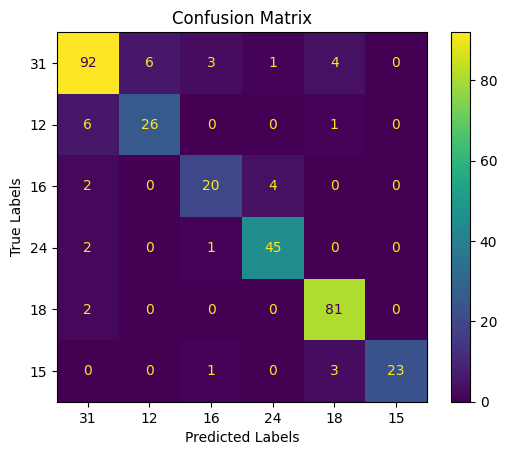

Accuracy: 0.8885448916408669
First few predictions: [31 31 31 31 31 16 31 31 31 31]
First few true labels: [31 31 31 31 31 31 31 31 31 31]
Correct predictions per food group:
31: 95 (Miscellaneous)
12: 26 (Cereals and cereal products)
16: 20 (Fruit products and dishes)
24: 41 (Vegetable products and dishes)
18: 88 (Meat, poultry and game products and dishes)
15: 17 (Fish and seafood products and dishes)


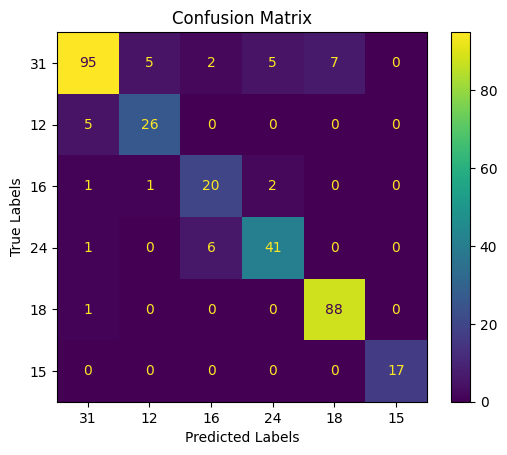

Average accuracy score across 5 CV splits: 0.8953980812597944


In [255]:
from sklearn.model_selection import cross_val_score, KFold
SPLIT_COUNT = 5

# splits the data into subsets
kfold = KFold(n_splits=SPLIT_COUNT, shuffle=True, random_state=43)

accuracy_scores = []
for train, test in kfold.split(data):
    # create design matrix X and predictions y
    X_train = data.iloc[train][X_COLS]
    y_train = data.iloc[train][y_COL]
    X_test = data.iloc[test][X_COLS]
    y_test = data.iloc[test][y_COL]

    # reinitialise knn model
    knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)

    # replace NaN values with 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    # train the model using the training subset
    knn.fit(X_train, y_train)
    
    # predict and show
    y_pred = predict_y(X_test)
    print_accuracy_and_predictions(y_test, y_pred)
    print_cm(y_test, y_pred)

    # add accuracy to list
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# print average accuracy
print(f"Average accuracy score across {len(accuracy_scores)} CV splits: {sum(accuracy_scores) / len(accuracy_scores)}")